# Imports and reading the data

In [7]:
# Imports and reading the data
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches 
import random
from collections import defaultdict
from shapely.geometry import Polygon
import operator
import sys

seed = 27

In [2]:
#reading the data
df = pd.read_csv('escorts.txt', delim_whitespace=True, index_col=False)

df_copy = df.copy()

#creating new columns in df that adds: year, month and day
df_copy['datetime'] = pd.to_datetime(df_copy['timestamp'], unit='s')

df_copy['year'] = df_copy['datetime'].dt.year
df_copy['month'] = df_copy['datetime'].dt.month
df_copy['day'] = df_copy['datetime'].dt.day

#dropping column datetime
df_copy = df_copy.drop(columns=['datetime'])

#getting rid of the timestamp
df_no_time = df.drop('timestamp', axis=1)
df_no_time.to_csv('escorts.csv', index =False, header=False)

df_no_time


,n1,n2,e
0,1,1,0
1,1,2,1
2,1,3,0
3,2,1,0
4,3,4,0
...,...,...,...
50627,8491,6621,0
50628,9136,6622,1
50629,6325,6456,1
50630,10105,6623,1


## Creating graphs

In [3]:
#creating different IDs for buyers(a) and escorts(b), so the nx function could read it
df_no_time['n1'] = 'a' + df_no_time['n1'].astype(str)

df_no_time['n2'] = 'b' + df_no_time['n2'].astype(str)

#collapsing the edges where one buyer rated the same girl more than 1 time
main_df = df_no_time.groupby(['n1', 'n2'], as_index=False).mean() #yes, it creates the means if they went to more than one escort
main_df

n1_list = main_df['n1'].tolist()
n2_list = main_df['n2'].tolist()
#projecting the bipartite graph using vectorized projection
G = nx.from_pandas_edgelist(main_df, 'n1', 'n2', 'e')

#projecting onto the escorts
proj_G = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n2.unique(), ratio=True) #ratio is number of common neighbors devided by number of buyers

#projecting onto the buyers
proj_G_b = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n1.unique(), ratio=True)

## Visualisation

### Bipartite Network Graph with bipartite_layout

/Users/renatasapeta/anaconda3/lib/python3.11/site-packages/networkx/readwrite/pajek.py:93: UserWarning: Edge attribute e is not processed. Non-string attribute.
  warnings.warn(


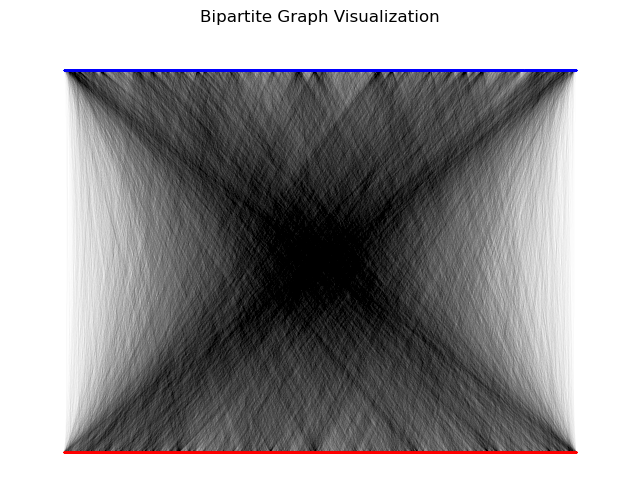

In [4]:

from networkx.drawing.layout import bipartite_layout
nx.write_pajek(G, "output_file_G.net")
network_G = nx.read_pajek("output_file_G.net")

#############################
#didnt work out for me
#G_bp = nx.DiGraph()
#G_bp.add_nodes_from()
# G.add_nodes_from("n1", bipartite=0)  # Assign 'bipartite' attribute 0 to nodes 1, 2, 3, 4
# G.add_nodes_from("n2", bipartite=1)  # Assign 'bipartite' attribute 1 to nodes 'a', 'b', 'c'

# Assigning node sets based on their bipartite attributes
# top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
# bottom_nodes = set(G) - top_nodes
#############################

top_nodes = n1_list
bottom_nodes = n2_list

# Positioning the nodes using bipartite_layout, I used horizontal but can be vertical
pos = nx.bipartite_layout(network_G, top_nodes, align='horizontal')


plt.figure(figsize=(8, 6))

nx.draw_networkx_nodes(network_G, pos, nodelist=top_nodes, node_color='red', node_size=0.005)
nx.draw_networkx_nodes(network_G, pos, nodelist=bottom_nodes, node_color='blue', node_size=0.005)

nx.draw_networkx_edges(network_G, pos, width=0.005, edge_color='black')


plt.title('Bipartite Graph Visualization')
plt.axis('off')
plt.show()

### Bipartite Network Graph with spring_layout

In [5]:

pos = nx.spring_layout(network_G, k=0.15)

plt.figure(figsize=(9, 9))
nx.draw_networkx_nodes(network_G, pos, nodelist=top_nodes, node_color='skyblue', node_size=2)
nx.draw_networkx_nodes(network_G, pos, nodelist=bottom_nodes, node_color='salmon', node_size=2)
nx.draw_networkx_edges(network_G, pos, width=0.15, edge_color='gray')

#nx.draw(network_G, pos, node_size=10, node_color='red', edge_color='black')

plt.title('Network Graph')
plt.show()
nx.write_pajek(G, "output_file_G.net")
network_G = nx.read_pajek("output_file_G.net")

KeyboardInterrupt: 

### Network Graph without nodes kinds recognision

In [6]:
pos = nx.spring_layout(network_G, k=0.15)

plt.figure(figsize=(6, 6))
nx.draw(network_G, pos, node_size=10, node_color='red', edge_color='black')
plt.title('Network Graph')
plt.show()

KeyboardInterrupt: 

# Functions

In [8]:

def give_condom(df, buyers_list):
    '''
    Function that gives condom to all the buyers in buyers_list
    and returns the DataFrame with updated edge
    '''


    mask = df['n1'].isin(buyers_list)
    df.loc[mask, 'e'] = 0.365*(1-0.8)

    return df

def count_unique_person2(df):
    """
    Count the unique person2 for each person1 and return a dictionary.

    Parameters:
    - df: pandas DataFrame with columns 'person1' and 'person2'

    Returns:
    - Dictionary with person1 as key and the count of unique person2 as value
    """

    # Group by 'person1' and count unique values in 'person2' for each group
    result_df = df.groupby('n1')['n2'].nunique().reset_index()

    # Convert the result to a dictionary
    result_dict = dict(zip(result_df['n1'], result_df['n2']))
    sorted_result_dict = dict(sorted(result_dict.items(), key=operator.itemgetter(1), reverse=True))


    return sorted_result_dict

top_b_links = count_unique_person2(df_no_time)
# Our simple SI function.

def si_simple(B, i_nodes):
   #so we can perform graph functions
   G = nx.Graph()
   G.graph.update(B.graph)
   G.add_nodes_from((n, B.nodes[n]) for n in B.nodes)
   
   new_infected = i_nodes.copy()
   for i_node in i_nodes:
        s_neighbors_of_i = {n for n in B.neighbors(i_node)}
        if len(s_neighbors_of_i) == 0:
            pass
        for s_node in s_neighbors_of_i:
            beta = B.get_edge_data(i_node, s_node, default=0)['weight'] #probability of spreading the disease
            if random.random() < beta:
                new_infected.add(s_node)
   return new_infected


#SIS model, doesn't work yet

# A function to make the simple IS step. Loop over
# all neighbors of nodes in I and transition them
# to S with probability mu.

def recovery(B, i_nodes, mu):
   #so we can perform graph functions
   G = nx.Graph()
   G.graph.update(B.graph)
   G.add_nodes_from((n, B.nodes[n]) for n in B.nodes)

   new_infected = i_nodes.copy()
   for i_node in i_nodes:
      if random.random() < mu:
         new_infected.remove(i_node)
   return new_infected

# Wrapper function
def sis(B, i_nodes, mu):
   #so we can perform graph functions
   G = nx.Graph()
   G.graph.update(B.graph)
   G.add_nodes_from((n, B.nodes[n]) for n in B.nodes)

   new_infected = i_nodes.copy()
   new_infected = si_simple(G, new_infected)
   new_infected = recovery(G, new_infected, mu)
   return new_infected

def weightz(G, u, v):
    ''' 
    Assigns weights to the edges in the projected graph based on the average weight of edges between
    u, v and their common neighbors in the original graph.

    Arguments:
        G : graph
            A NetworkX undirected bipartite graph.

        u, v : nodes
            Nodes in the graph.

    Returns:
        w: float

    Raises:
        NetworkXError
            If u or v is not a node in the graph.
    '''
    if u not in G:
        raise nx.NetworkXError("u is not in the graph.")
    if v not in G:
        raise nx.NetworkXError("v is not in the graph.")

    w = 0
    nbrs = nx.common_neighbors(G, u, v)
    for i, n in enumerate(nbrs):
        w += G.get_edge_data(u, n).get('e')
        w += G.get_edge_data(v, n).get('e')
    w = w/(2*(i+1))
    return w
    
def whos_faster(model1, model2):
    k1 = 0
    for k,v in model1.items():
        if v>92:
            k1=k
            break
    for k,v in model2.items():
        if v>92:
            k2=k
            break
    return k1/k2

# Basic network analysis

### On the bipartite network

In [ ]:
#finding unique number of buyers and escorts
buyers = df.n1.unique().tolist()
escorts = df.n2.unique().tolist()

print(f'Unique edge count: {G.size()}')
print(f'Total number of nodes: {G.number_of_nodes()}')
print(f'Numbers of buyers: {len(buyers)}')
print(f'Numbers of escorts: {len(escorts)}')
print(f'Total number of rows: {df_no_time.shape[0]}') #num of encounters
print(f'Is the network connected? {nx.is_connected(G)}') 

avg_rating = round(float(df_no_time['e'].mean()), 3)
print(f'Average rating: {avg_rating}') #most of them satisfied ;)
#Largest Connected Component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
LCC = G.subgraph(Gcc[0])
print(f'LCC size {LCC.size()}')
print(f'Number of unique edges are out of the LCC: {G.size() - LCC.size()}')

#finding most popular buyers(biggest amount of payments) and escorts(how many times visited)
#we need to observe that the escorts that had less buyers and had rating of 1, will have better scores than the most visited ones
#so we need to normalize it

#on df_no_time, because it contains the edges before collapsing them

#Making dataframe of popular buyers and popular escorts
pop_buyers = df_no_time['n1'].value_counts().reset_index()
pop_escorts = df_no_time['n2'].value_counts().reset_index()

#Making list of the 10 most popular buyers
b_top10 = pop_buyers['index'].head(10).tolist()
 
#Making list of the 10 most popular escorts
e_top10 = pop_escorts['index'].head(10).tolist()

#Dictionary of average rating of most vistied escorts (top 10 degrees)
#Key: ID of escort
#Value: Average rating
avg = {}
for escort in e_top10:
    most_pop_esc = df_no_time[df_no_time['n2'] == escort]
    ratings = most_pop_esc['e'].tolist()
    avg[escort] = round(sum(ratings)/len(ratings), 3)

print(f'Average ratings {avg}')
#Average degrees

avg_d_b = round(float(pop_buyers['n1'].mean()), 3)
print(f'Average degree of buyers: {avg_d_b}') #how many ratings they've given

avg_d_e = round(float(pop_escorts['n2'].mean()), 3)
print(f'Average degree of escorts: {avg_d_e}') #how many times they've been rated

### On the projections

In [ ]:
#number of singletons
degrees = nx.degree(proj_G)

n = 0
for key, value in degrees:
    if value == 0:
        n += 1
print(f'Numbers of singletons: {n}')

#basic network analysis on projected network
# proj_G.size() #num of edges
print(proj_G.number_of_edges())
print(proj_G.number_of_nodes())

#density it's a range 0-1
print(f' Density {nx.density(proj_G)}') #quite sparse 

### Laplace's Rule of Succesion 

In [ ]:
# Define Laplace's Rule of Succession function with weighted ratings
def laplace_rule_of_succession(df, rating_weights={'positive': 1, 'neutral': 0.5, 'negative': -1}):
    # Calculate the total number of reviews for each escort
    reviews_count = df.groupby('n2')['e'].count().reset_index()
    reviews_count.rename(columns={'e': 'TotalReviews'}, inplace=True)

    # Calculate the total weight for each escort
    weighted_reviews = df.groupby(['n2'])['e'].sum().reset_index()
    weighted_reviews.rename(columns={'e': 'TotalWeight'}, inplace=True)

    # Merge the weight information back into the main dataframe
    df = pd.merge(df, reviews_count, on='n2', how='left')
    df = pd.merge(df, weighted_reviews, on='n2', how='left')

    # Calculate Laplace-adjusted ratings with weighted ratings
    df['LaplaceAdjustedRating'] = (df['TotalWeight'] + rating_weights['positive']) / (df['TotalReviews'] + sum(rating_weights.values()))

    return df


df_test = laplace_rule_of_succession(main_df)
df_test

## Degree distribution

In [ ]:

#degrees in the bipartite network
bi_escorts_degrees = Counter(main_df['n2'])

bi_buyers_degrees = Counter(main_df['n1'])

#degrees in the projected
escorts_degrees = dict(proj_G.degree())
buyers_degrees = dict(proj_G_b.degree())
#Plotting degree distribution
fig, ax = plt.subplots(2, 2)

ax[0, 0].hist(bi_escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color='#FFAA75')
ax[0,0].set_xscale('log')

ax[0, 1].hist(bi_buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = '#9C5FFF')
ax[0,1].set_xscale('log')

ax3 = ax[1, 0].hist(escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color ='#FFAA75')
ax[1,0].set_xscale('log')

ax4 = ax[1, 1].hist(buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = '#9C5FFF')
ax[1,1].set_xscale('log')

fig.supxlabel('Degree')
fig.supylabel('Frequency')

green_patch = mpatches.Patch(color='#FFAA75', label='Escorts') 
blue_patch = mpatches.Patch(color='#9C5FFF', label='Buyers') 
fig.legend(handles=[green_patch, blue_patch], loc='upper right') 
ax[0,0].set_title('In the bipartite network', loc='left')
ax[1,0].set_title('In the network projected onto escorts', loc='left')
fig.suptitle('Degree distribution')
fig.subplots_adjust(hspace=0.7, top=0.85)

plt.show()

### Cumulative degree distribution

In [ ]:



degree_sequence = sorted([d for n, d in G.degree()], reverse=True) #the degree of each nod
# accumulating the degrees from highest to lowest
cumulative_degrees = [degree_sequence[:i].count(degree) for i, degree in enumerate(degree_sequence)]
plt.plot(degree_sequence, cumulative_degrees, marker='o')
plt.xlabel("Degree")
plt.ylabel("Cumulative Degree Distribution")
plt.title("Cumulative Degree Distribution")
plt.grid(True)
plt.show()

# Calculating centralities to detect the hubs of the network

### Degree centrality

In [ ]:
d_cent = nx.degree_centrality(proj_G)

#top 10
d_c_sorted = {k: v for k, v in sorted(d_cent.items(), key=lambda item: item[1], reverse=True)[:10]}
peri1 = {k: v for k, v in sorted(d_cent.items(), key=lambda item: item[1], reverse=False)if v >0}
peri = {k: v for k, v in sorted(peri1.items(), key=lambda item: item[1], reverse=False)[:10]}
peri

### Betweenness centrality

In [ ]:
b_cent = nx.betweenness_centrality(proj_G, k=1000)

#top 10
b_c_sorted = {k: v for k, v in sorted(b_cent.items(), key=lambda item: item[1], reverse=True)[:10]}

### Closeness centrality

In [ ]:
c_cent = nx.closeness_centrality(proj_G)

#top 10
c_c_sorted = {k: v for k, v in sorted(c_cent.items(), key=lambda item: item[1], reverse=True)[:10]}

In [ ]:
#the algorithm was designed for directed graph, but it gives us some idea of hubs
hity = nx.hits(proj_G)
hity = dict(hity[0])

#top 10
hits_sorted = {k: v for k, v in sorted(hity.items(), key=lambda item: item[1], reverse=True)[:10]}



In [ ]:
# Merging all 4 hub detection techniques to find unique hubs they present
hubs = list(b_c_sorted.keys()) + list(d_c_sorted.keys()) + list(c_c_sorted.keys()) + list(hits_sorted.keys())
hubs = set(hubs)
len(hubs)

# Community detection

In [ ]:

#Community Detection
lab_prop = nx.community.label_propagation_communities(proj_G)
modularity = nx.community.greedy_modularity_communities(proj_G)

listed_lab = list(lab_prop)
listed_lab.sort(key=len, reverse=True)
#number of nodes in each community
for i in range(12):
    print(len(modularity[i]))

print("_________________________")

for i in range(12):
    print(len(listed_lab[i]))

# Cliques

clique = cohesive group of people that are tightly connected to each other (and not tightly connected to people outside the group)
it's also -> maximal complete subgraph of a given graph



maximum clique = cannot be enlarged by adding one more neighboring vertex, i.e. one that does not reside only within the vertex set of a bigger clique. A clique in an undirected graph is a complete subgraph of the given graph.


In [ ]:
print(sys.getrecursionlimit()) #checking what is our limit :((

sys.setrecursionlimit(1000000) #setting it to crazy cause our network is big

#this is so th eerror of the limit size doesn't occur
def shut_down(s):
    if (s == "yes"):
        return "Shutting down"
    elif (s == "no"):
        return "shutdown aborted"
    else :
        return "Sorry" 

## Visualising projected network on the buyers

### Number of cliques

In [ ]:

Number of cliques = 34
Sparse Connectivity: Having only 34 cliques in a network of 10,000 nodes suggests that the network is relatively sparse overall. This means that while there are tightly connected subsets (cliques), the connections between these subsets might be limited.
 

def find_cliques(proj_G_b):
    cliques = []
    visited = set()
 
    def dfs(node, clique):
        visited.add(node)
        clique.add(node)
 
        for neighbor in proj_G_b[node]:
            if neighbor not in visited:
                dfs(neighbor, clique)
 
    for node in proj_G_b:
        if node not in visited:
            clique = set()
            dfs(node, clique)
            if len(clique) > 1:
                cliques.append(clique)
 
    return cliques
 
 
# usage
#find_cliques() performs a depth-first search (DFS) on the graph
 
cliques = find_cliques(proj_G_b)
print(f'Number of cliques: {len(cliques)}')
print(f'Cliques: {cliques}')